# Importing required Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import scipy.io.wavfile
import glob
import json
import tensorflow as tf
import keras

from scipy import signal
from python_speech_features import mfcc
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.utils import np_utils
from keras.models import model_from_json

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Visual Representation of Data and MFCC feature

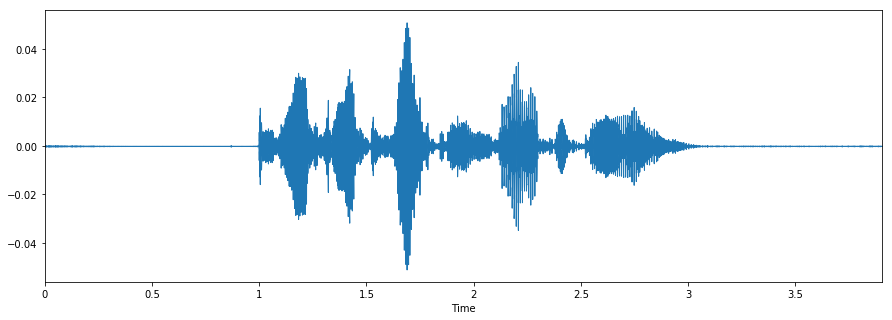

In [2]:
my_audio_list = os.listdir('/home/dev-ml/Documents/Notebooks/Audio_Speech_Actors_01-24')
data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio_Speech_Actors_01-24/03-01-01-01-01-01-07.wav')
plt.figure(figsize=(15,5))
librosa.display.waveplot(data, sr=sampling_rate)

In [3]:
sr,x = scipy.io.wavfile.read('/home/dev-ml/Documents/Notebooks/Audio_Speech_Actors_01-24/03-01-01-01-01-01-07.wav')
mfcc_feat = mfcc(x, sr)

/home/dev-ml/flask/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


[  7.70654995 -46.27866368 -27.32074951  -5.3916903    1.53572846
  12.58461116   0.71052065  22.73497937 -12.95599087  -5.12919736
  16.448636     4.70310315   1.01247012]


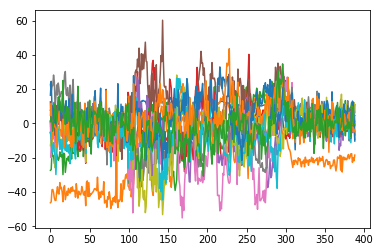

In [61]:
print(mfcc_feat[0])
plt.plot(mfcc_feat)
plt.show()

# Label Tagging

In [5]:
feeling_list=[]
for item in my_audio_list:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
        
labels = pd.DataFrame(feeling_list)

# Getting MFCC(audio feature) using librosa

In [44]:
df = pd.DataFrame(columns=['MFCC_feature'])
bookmark = 0
for index, y in enumerate(my_audio_list):
    if my_audio_list[index][6:-16]!='01' and my_audio_list[index][6:-16]!='07' and my_audio_list[index][6:-16]!='08':
        X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio_Speech_Actors_01-24/'+y, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12), axis = 0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark = bookmark+1

# Making feature as list

In [7]:
df1 = pd.DataFrame(df['MFCC_feature'].values.tolist())
features_df = pd.concat([df1, labels], axis = 1)
features = features_df.rename(index=str, columns={"0":"labels"})

# Data Shuffling and Splitting for Train Validation and Test

In [8]:
shuffled_features = shuffle(features_df)
shuffled_features = shuffled_features.fillna(0)
dataframe_to_split = np.random.rand(len(shuffled_features))<0.8
train= shuffled_features[dataframe_to_split]
test = shuffled_features[~dataframe_to_split]
#train_validation_split = np.random.rand(len(train_validation))<0.8
#train = train_validation[train_validation_split]
#validation = train_validation[~train_validation_split]
print(f"Number of Samples in Training set: {len(train)}" 
      #f"Number of Samples in Validation set: {len(validation)}" 
       f"Number of Samples in Test set: {len(test)}")

Number of Samples in Training set: 768Number of Samples in Test set: 192


In [9]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
188,-29.514870,-31.776139,-36.120101,-35.954008,-35.894216,-35.951364,-34.607066,-35.883417,-36.135357,-37.427406,...,-45.210504,-46.084817,-45.995474,-46.169773,-46.866463,-47.589461,-48.592283,-48.842870,-50.810683,male_sad
335,-52.144882,-53.959018,-55.145461,-53.612339,-52.147070,-49.463857,-49.172999,-52.111884,-53.611675,-50.524048,...,-50.998890,-52.317006,-51.349279,-51.088707,-51.130629,-50.069041,-50.267326,-51.520944,-52.932136,female_sad
796,-45.908652,-45.037728,-43.177266,-44.306586,-43.855285,-42.854336,-41.871649,-43.492264,-44.033440,-43.267519,...,-52.668621,-52.844928,-53.422032,-53.422032,-53.412747,-53.422032,-53.422032,-53.422032,-53.422032,male_angry
714,-60.035415,-57.628305,-59.567266,-57.989046,-55.944638,-55.334597,-54.096814,-54.163590,-54.132263,-55.434508,...,-55.452404,-54.189151,-51.989857,-52.993306,-53.788878,-53.900717,-60.371747,-61.165162,-61.363281,male_fearful
135,-31.163712,-28.617668,-24.917966,-24.494932,-24.846596,-25.156173,-24.030118,-25.511892,-27.973814,-31.118020,...,-36.447712,-36.467863,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,-36.526012,female_fearful
72,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,-71.288347,...,-45.439756,-45.199464,-43.801681,-44.768454,-46.546834,-45.922287,-46.734531,-42.166701,-37.963118,female_calm
791,-44.885854,-45.082421,-47.076502,-46.610296,-46.318369,-47.088493,-48.267672,-47.895986,-48.130202,-48.102341,...,-33.019653,-35.128218,-38.451996,-36.806465,-37.327523,-38.855880,-40.543094,-40.002530,-41.686634,male_happy
431,-54.708324,-54.653338,-52.725850,-51.453863,-51.366225,-46.573400,-45.788272,-50.593786,-51.468436,-52.202106,...,-25.084328,-24.531931,-22.930950,-23.040788,-24.449135,-27.638992,-28.012611,-23.535640,-20.127318,male_sad
467,-58.422295,-58.422295,-58.535201,-58.431621,-57.747075,-57.535263,-58.422295,-58.398279,-58.344954,-58.380276,...,-46.481235,-45.848121,-48.013794,-46.745736,-46.297077,-48.637232,-49.142133,-47.933007,-48.412836,male_fearful
669,-47.565071,-47.565071,-47.565071,-47.565071,-47.425577,-47.180192,-47.169192,-46.819389,-46.011608,-45.685650,...,-38.076346,-36.199821,-35.685927,-36.506392,-34.409975,-31.955710,-30.968075,-22.424756,-13.516900,female_fearful


# Label Encoding

In [10]:
trainfeatures = train.iloc[:, :-1]

trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]


X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/home/dev-ml/flask/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
X_train.shape

(768, 216)

# Expanding Dimensionality for CNN

In [12]:
x_traincnn = np.expand_dims(X_train, axis = 2)
#x_validationcnn = np.expand_dims(x_validation, axis = 2)
x_testcnn = np.expand_dims(X_test, axis = 2)

# Model and Summary of model

In [13]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

# Data Fitting to Model

In [29]:
cnnmodel = model.fit(x_traincnn, y_train, batch_size=32, epochs=300, validation_data=(x_testcnn, y_test))

Train on 768 samples, validate on 192 samples
Epoch 1/300
768/768 [==============================] - 0s 162us/step - loss: 1.4691 - acc: 0.4674 - val_loss: 1.6354 - val_acc: 0.3333
Epoch 2/300
768/768 [==============================] - 0s 159us/step - loss: 1.4741 - acc: 0.4310 - val_loss: 1.5724 - val_acc: 0.3438
Epoch 3/300
768/768 [==============================] - 0s 153us/step - loss: 1.4715 - acc: 0.4206 - val_loss: 1.5767 - val_acc: 0.3333
Epoch 4/300
768/768 [==============================] - 0s 147us/step - loss: 1.4824 - acc: 0.4167 - val_loss: 1.5743 - val_acc: 0.3646
Epoch 5/300
768/768 [==============================] - 0s 146us/step - loss: 1.4891 - acc: 0.4375 - val_loss: 1.5699 - val_acc: 0.3646
Epoch 6/300
768/768 [==============================] - 0s 144us/step - loss: 1.4417 - acc: 0.4401 - val_loss: 1.6373 - val_acc: 0.3490
Epoch 7/300
768/768 [==============================] - 0s 143us/step - loss: 1.4574 - acc: 0.4336 - val_loss: 1.5690 - val_acc: 0.3542
Epoch 8/3

# Training and Validation Loss

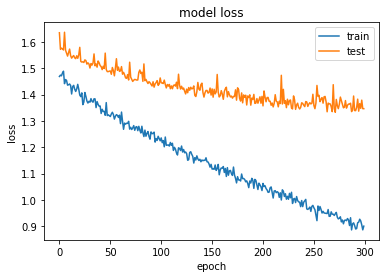

In [31]:
plt.plot(cnnmodel.history['loss'])
plt.plot(cnnmodel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

# Acuuracy Plot

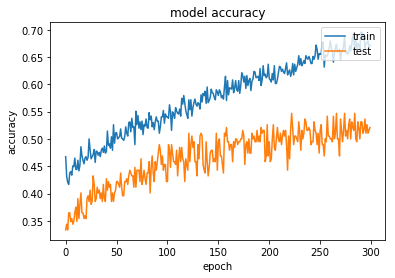

In [32]:
plt.plot(cnnmodel.history['acc'])
plt.plot(cnnmodel.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

# Saving Model

In [33]:
model_name='Speech_Emotion_Detecor_to_demo_50.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
#save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save trained model at %s'%model_path)

Save trained model at /home/dev-ml/Documents/Notebooks/saved_models/Speech_Emotion_Detecor_to_demo_300.h5


# Loading Model

In [222]:
#Loading json and creating model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load weights into new model
#loaded_model.load_weights("/home/dev-ml/Documents/Notebooks/saved_models/Speech_Emotion_Detecor_to_demo_300.h5")
#loaded_model.load_weights("/home/dev-ml/Documents/Notebooks/saved_models/Speech_Emotion_Detecor_to_demo_50_1.h5")
loaded_model.load_weights("/home/dev-ml/Documents/Notebooks/saved_models/Speech_Emotion_Detecor_to_demo_50.h5")
print("Loaded model from disk")
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

#evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" %(loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 88.54%


# Test Data Predictions

In [91]:
preds = loaded_model.predict(x_testcnn, batch_size=4, verbose=1)
pred1 = preds.argmax(axis=1)
label_name = pred1.astype(int).flatten()
predictions = (lb.inverse_transform(label_name))
prediction_df = pd.DataFrame({'prediction_values':predictions})

actual = y_test.argmax(axis=1)
actual_label_name = actual.astype(int).flatten()
actual_values = (lb.inverse_transform((actual_label_name)))
actual_values_df = pd.DataFrame({'actual_values':actual_values})

predicted_actual_df = actual_values_df.join(prediction_df)
predicted_actual_df[170:180]
#prediction_df.groupby('actual_values').count()
#prediction_df.groupby('prediction_values').count()

192/192 [==============================] - 0s 542us/step


,actual_values,prediction_values
170,female_happy,male_sad
171,female_happy,female_calm
172,female_sad,female_happy
173,male_fearful,female_happy
174,female_happy,female_calm
175,female_sad,female_happy
176,female_angry,female_sad
177,female_angry,female_happy
178,female_calm,female_sad
179,male_sad,male_fearful


# Real Time Prediction for Recordings

In [69]:
import pyaudio
import wave


CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "prediction_try.wav"

p = pyaudio.PyAudio()

stream = p.open(format = FORMAT, channels = CHANNELS, rate = RATE, input = True, frames_per_buffer=CHUNK)
print("*recording*")

frames = []

for i in range(0, int(RATE/CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    
print("*Done Recording*")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

*recording*
*Done Recording*


# Data Loading and Preprocessing for prediciton

In [254]:
# data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/female600.wav')#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/output10.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/OSR_us_000_0012_8k.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/OSR_us_000_0031_8k.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/Ja_calm.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/Ja_angry.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_angry.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_calm.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_fearful.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_happy.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#data, sampling_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_sad.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)

# plotting the wave file
# plt.figure(figsize=(15,5))
# librosa.display.waveplot(data, sr=sampling_rate)
# sr,x = scipy.io.wavfile.read('C:/Users/aulaganathan/Desktop/female600.wav')
# mfcc_feat = mfcc(x, sr)
# print(mfcc_feat)
# plt.plot(mfcc_feat)
# plt.show()


#Getting MFCC for prediction sample
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/female600.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/output10.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/OSR_us_000_0012_8k.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/OSR_us_000_0031_8k.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/Ja_calm.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/Ja_angry.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_angry.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_calm.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_fearful.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_happy.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/josh_mcphail_sad.wav', res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/OAF_youth_angry.wav', res_type='kaiser_fast', duration=2.5, sr=51000*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/YAF_youth_fear.wav', res_type='kaiser_fast', duration=2.5, sr=44400*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/YAF_youth_sad.wav', res_type='kaiser_fast', duration=2.5, sr=29400*2, offset=0.5)
#X, sample_rate = librosa.load('/home/dev-ml/Documents/Notebooks/Audio-Samples/YAF_youth_happy.wav', res_type='kaiser_best', duration=2.5, sr=34200*2, offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis = 0)
feature_1 = mfccs 

#making featrure as Dataframe 
livedf2= pd.DataFrame(data=feature_1)
livedf2 = livedf2.stack().to_frame().T
twodim = np.expand_dims(livedf2, axis=2)

#Live Prediction
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

testpreds = livepreds.argmax(axis=1)
testabc = testpreds.astype(int).flatten()
livepredictions = (lb.inverse_transform((testabc)))
livepredictions

1/1 [==============================] - 0s 8ms/step


array(['male_angry'], dtype=object)